In [1]:
from data_mining import get_all_text, fb
from tokenizer_digital_language.custom_tokenizer import SpacyCustomTokenizer
import os
from script_to_data_analysis.tools import get_progressbar

texts = get_all_text(f'{os.getcwd()}/data_mining/')
nlp = SpacyCustomTokenizer()

/Users/dany/.local/share/virtualenvs/cuba-digital-lang-9Kd57kqM/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_tokens = []
super_text = []
vocabulary = set('$END')
bar = get_progressbar(len(texts), f' {len(texts)} Tokenizer texts ')
bar.start()
for i, tupl in enumerate(texts):
    text, _ = tupl
    temp = []
    for token in nlp(text):
        vocabulary.add(token.text)
        temp.append(token.text)
    text_tokens.append(temp)
    super_text += temp + ['$END']
    bar.update(i+1)
bar.finish()

[#################################################] 289419 Tokenizer texts 100%


In [3]:
vocabulary = sorted(vocabulary)
len(vocabulary)

253077

## Tensorflow (Structure Data Set)

In [4]:
from keras.layers import StringLookup
from tensorflow.strings import reduce_join
from tensorflow.data import Dataset, experimental
import numpy as np

In [5]:
ids_from_words = StringLookup(
    vocabulary=list(vocabulary), mask_token=None)

words_from_ids = StringLookup(
    vocabulary=ids_from_words.get_vocabulary(), invert=True, mask_token=None)


def text_from_ids(ids):
  return reduce_join(words_from_ids(ids), axis=-1)

2022-06-09 00:11:51.327511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 00:11:51.331173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [6]:
idx_text = ids_from_words(super_text)
ids_dataset = Dataset.from_tensor_slices(idx_text)

In [7]:
seq_length = 15
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [8]:
def split_input_target(sequence):
    return sequence[:-1],sequence[-1]

dataset = sequences.map(split_input_target)

In [9]:
# Batch size
BATCH_SIZE = 50
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

full_dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(experimental.AUTOTUNE))

DATASET_SIZE = len(full_dataset)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print(f"""
Total Batches Data Set: {DATASET_SIZE}
Training: {train_size}
Validation: {val_size}
Test: {test_size}
""")


Total Batches Data Set: 13435
Training: 9404
Validation: 2015
Test: 2015



## Tensorflow (Model Def and Training)

In [10]:
from tensorflow.keras import Model
from keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow import squeeze, random, losses, metrics, exp

In [11]:
embedding_dim = 8
rnn_units = seq_length * embedding_dim
lstm_layers = 3

embedding = Embedding(len(vocabulary), embedding_dim)
lstm_list =[  LSTM(rnn_units, 
    input_shape=(BATCH_SIZE, seq_length, embedding_dim),
    dropout=0.2,
    recurrent_dropout=0.2,
    return_state=True,
    return_sequences=True
) for _ in range(lstm_layers -1)]

lstm_final = LSTM(rnn_units, dropout=0.2, recurrent_dropout=0.2)
dense =  Dense(len(vocabulary), activation='softmax')

In [12]:
seq_input = Input((seq_length,), batch_size=BATCH_SIZE)
x = embedding (seq_input)
for i, lstm in enumerate(lstm_list):
  if i == 0:
    x, state_h, state_c = lstm (x)
  else: 
    x, state_h, state_c = lstm (x, initial_state=[state_h, state_c])  
x = lstm_final (x, initial_state=[state_h, state_c])
output = dense(x)

model = Model(inputs=seq_input, outputs=output, name="rnn")
model.summary()

Model: "rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(50, 15)]           0           []                               
                                                                                                  
 embedding (Embedding)          (50, 15, 8)          2024616     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(50, 15, 120),      61920       ['embedding[0][0]']              
                                 (50, 120),                                                       
                                 (50, 120)]                                                       
                                                                                                

In [13]:
# plot_model(model, "my_first_model.png")

In [14]:
# for input_example_batch, target_example_batch in train_dataset.take(1):
#     example_batch_predictions = model(input_example_batch)
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")
#     print(example_batch_predictions)
#     print(target_example_batch)

In [15]:
# sampled_indices = random.categorical(example_batch_predictions, num_samples=1)
# sampled_indices = squeeze(sampled_indices, axis=-1).numpy()
# sampled_indices

In [16]:
# print("Input:\n", words_from_ids(input_example_batch[0]))
# print()
# print("Next Char Predictions:\n", words_from_ids(sampled_indices))

In [17]:
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.losses.BinaryCrossentropy(from_logits=True)
metric = metrics.SparseCategoricalAccuracy(name='accuracy')

In [18]:
# example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
# print("Mean loss:        ", example_batch_mean_loss)
# exp(example_batch_mean_loss).numpy()

## Tensorflow (Training)

In [19]:
from keras.callbacks import ModelCheckpoint
from tensorflow import train

In [20]:
model.compile(optimizer='adam', loss=loss, metrics=metric)

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

         

In [22]:
latest = train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [23]:
history = model.fit(
    train_dataset, 
    epochs=4, 
    callbacks=[checkpoint_callback], 
    validation_data=val_dataset
)


Epoch 1/4


/Users/dany/.local/share/virtualenvs/cuba-digital-lang-9Kd57kqM/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-06-09 00:12:36.534297: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 00:12:36.538920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9404/9404 [==============================] - ETA: 0s - loss: 4.0291 - accuracy: 0.3254

2022-06-09 04:16:10.442053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9404/9404 [==============================] - 14918s 2s/step - loss: 4.0291 - accuracy: 0.3254 - val_loss: 6.3637 - val_accuracy: 0.1960
Epoch 2/4
7757/9404 [=======================>......] - ETA: 42:55 - loss: 3.6919 - accuracy: 0.3638

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
history_dict.keys()

NameError: name 'model' is not defined

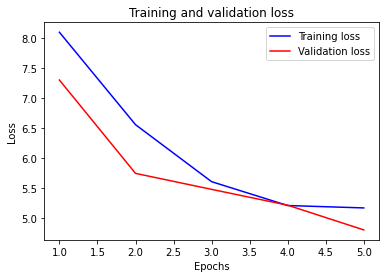

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

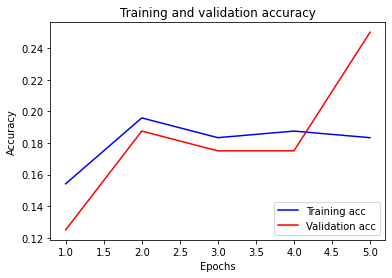

In [ ]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()